In [1]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.io import ascii
from scipy import stats
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import pymc3 as pm
# import theano.tensor as tt
# import arviz as az

# import warnings
# warnings.filterwarnings('ignore')

sns.set(style='ticks', context='talk')
plt.style.use("paper.mplstyle")

RNG = np.random.RandomState(952020)

## Data

* ```SNID```: SDSS SNe ID
* ```Age{i}```: randomly collected from MCMC chain (Rose et al. 2019). i = 0-9999
* ```HR{i}```: artificially created normal distribution from HR_uncertainty. i = 0-9999

In [2]:
DATAPATH = Path("./data")
RESULTSPATH = Path("./results")
DATASET = 'campbell'   # 'gupta' or 'campbell' or 'campbellG'
DATAFILE = Path('./data/HRvsAge_samples_campbell10k.csv')

In [3]:
samples = pd.read_csv(DATAFILE)
samples.head(3)

,SNID,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Age8,...,HR9990,HR9991,HR9992,HR9993,HR9994,HR9995,HR9996,HR9997,HR9998,HR9999
0,762,4.758532,1.558216,7.348196,4.922079,1.916873,8.067425,8.161599,3.595067,1.897597,...,0.125418,0.111031,0.049721,0.110228,0.061907,0.042606,0.070339,0.103706,0.087285,0.080275
1,1032,7.493606,10.350519,6.692530,5.663809,8.046976,3.958073,2.291889,3.648609,6.861651,...,-0.025980,-0.018704,0.003307,0.020747,-0.027311,-0.010247,-0.025592,0.028176,0.019976,-0.030866
2,1371,1.844475,9.785429,0.805218,10.507561,9.964770,9.645604,10.331896,2.330517,1.195014,...,-0.178016,-0.191690,-0.131175,-0.215081,-0.206989,-0.186684,-0.159390,-0.179546,-0.180692,-0.214565


In [4]:
num_samples = 10000 # 10k samples
length = 103
age_columns = ['Age{}'.format(i) for i in range(num_samples)]
HR_columns  = ['HR{}'.format(i) for i in range(num_samples)]

# put them together
Age_all = samples[age_columns].values.flatten()
HR_all = samples[HR_columns].values.flatten()

In [5]:
def create_age_sample_from_mcmc_chains(dataset, sample_size=10000, random_state=RNG):
    dataset_path = DATAPATH/"mcmc_chains"/"campbell"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    dfs = []
    all_dataset_files = list(dataset_path.glob("*.tsv"))
    for i, sn_chain_path in enumerate(all_dataset_files):
        print(f"{i}/{len(all_dataset_files)}", end="\r")
        # Get number of rows in file
        # Header takes up 2 rows
        nheaders = 2
        nrows = sum(1 for line in open(sn_chain_path)) - nheaders
        skiprows = [1] + sorted(random_state.choice(range(nheaders, nrows+nheaders), nrows-sample_size, replace=False))

        _df = pd.read_table(sn_chain_path, skiprows=skiprows, usecols=[7], index_col=False)
        
        # Set the index as the SNID parsed from its filename
        snid = re.findall("SN(\d+)_", sn_chain_path.name)[0]
        _df['snid'] = [snid]*len(_df)
        dfs.append(_df)
    print(f"{len(all_dataset_files)}/{len(all_dataset_files)}", end="\r")
        
    df = pd.concat(dfs)
    df.to_csv(DATAPATH/f"{dataset}_local_samples.tsv", sep="\t")
    return 

def load_age_sample_from_mcmc_chains(dataset, mode="read", **kwargs):
    """Return a random sample of the mcmc chains dataset for all SNe available.

    dataset : str {"campbell", "campbellG", "gupta"} 
        Dataset to load.
    mode : str {"read", "write"}
        If write, redo the creation of the mcmc chain sample and also write to file.
        WARNING: this may take a long time sampling from ~20GB of data.
        If read, the mcmc chain sample is read from cached output of the "write" mode.
    **kwargs : keyword arguments
        Used when mode="write" and passed onto the function `create_age_sample_from_mcmc_chains`.
    """
    dataset_path = DATAPATH/"mcmc_chains"/"campbell"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    if mode == "write":
        return create_age_sample_from_mcmc_chains(dataset, **kwargs)
    if mode == "read":
        return pd.read_table(DATAPATH/f"{dataset}_local_samples.tsv")
    
def load_hr(dataset):
    """
    dataset : str {"campbell", "campbellG", "gupta"} 
        Dataset to load.
    """
    dataset_path = DATAPATH/"campbell_local_r19t1.txt"
    assert dataset_path.exists(), f"{dataset_path} does not exists."
    
    return ascii.read(dataset_path).to_pandas()

### Sample of SNe Local Age MCMC Chain from R20 of Campbell Dataset 

In [6]:
# load_age_sample_from_mcmc_chains('campbell', mode="write")
age_df = load_age_sample_from_mcmc_chains('campbell', mode="read")
age_df = age_df.set_index("snid").sort_index()
display(age_df.head())

hr_df = load_hr("campbell")
hr_df = hr_df
hr_df.columns = hr_df.columns.str.lower()
hr_df = (hr_df.rename(columns={
    "sdss": "snid",
    "e_hr": "hr_err"
})
         .set_index("snid")
         .sort_index()[["hr", "hr_err"]])
display(hr_df.head())

in_age_not_hr = set(age_df.index) - set(hr_df.index)
in_hr_not_age = set(hr_df.index) - set(age_df.index)
print("Missing from R19 Table 1 of SNID:", in_age_not_hr)
print("Missing from Campbell MCMC chains of SNID:", in_hr_not_age)

# Inner join on SNID
age_df = age_df.drop(index=in_age_not_hr)
hr_df = hr_df.drop(index=in_hr_not_age)
snids = age_df.index.unique().tolist()

,age
snid,
762,2.021842
762,2.833909
762,2.580368
762,2.397617
762,2.629097


,hr,hr_err
snid,,
762,0.15,0.08
1032,-0.15,0.12
1371,-0.14,0.06
1794,0.27,0.08
2372,-0.12,0.07


Missing from R19 Table 1 of SNID: {15459}
Missing from Campbell MCMC chains of SNID: {3256}


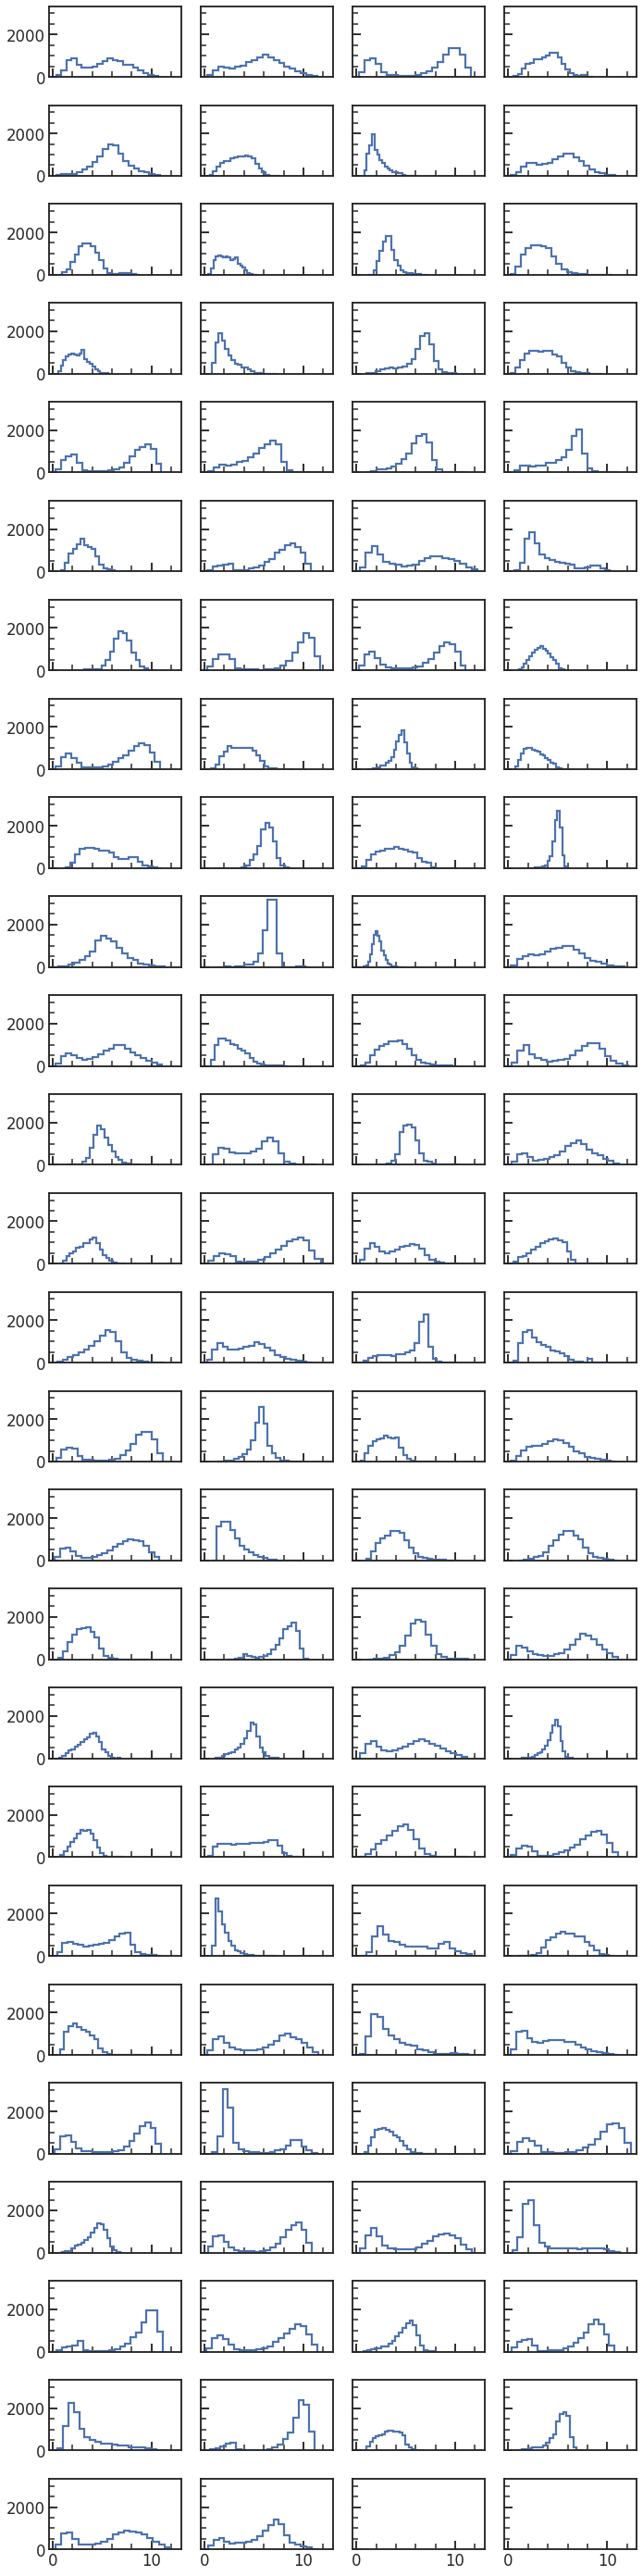

In [7]:
nrows, ncols = np.ceil(len(snids)/4).astype(int), 4
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5/2, nrows*3/2), sharex=True, sharey=True)

for i, snid in enumerate(snids):
    print(i, snid, end="\r")
    ax = axes[i//ncols, i%ncols]
    ax.hist(age_df.loc[snid, 'age'], bins=20, histtype='step')
    
plt.tight_layout()

## Make plots

### (2-1) individual

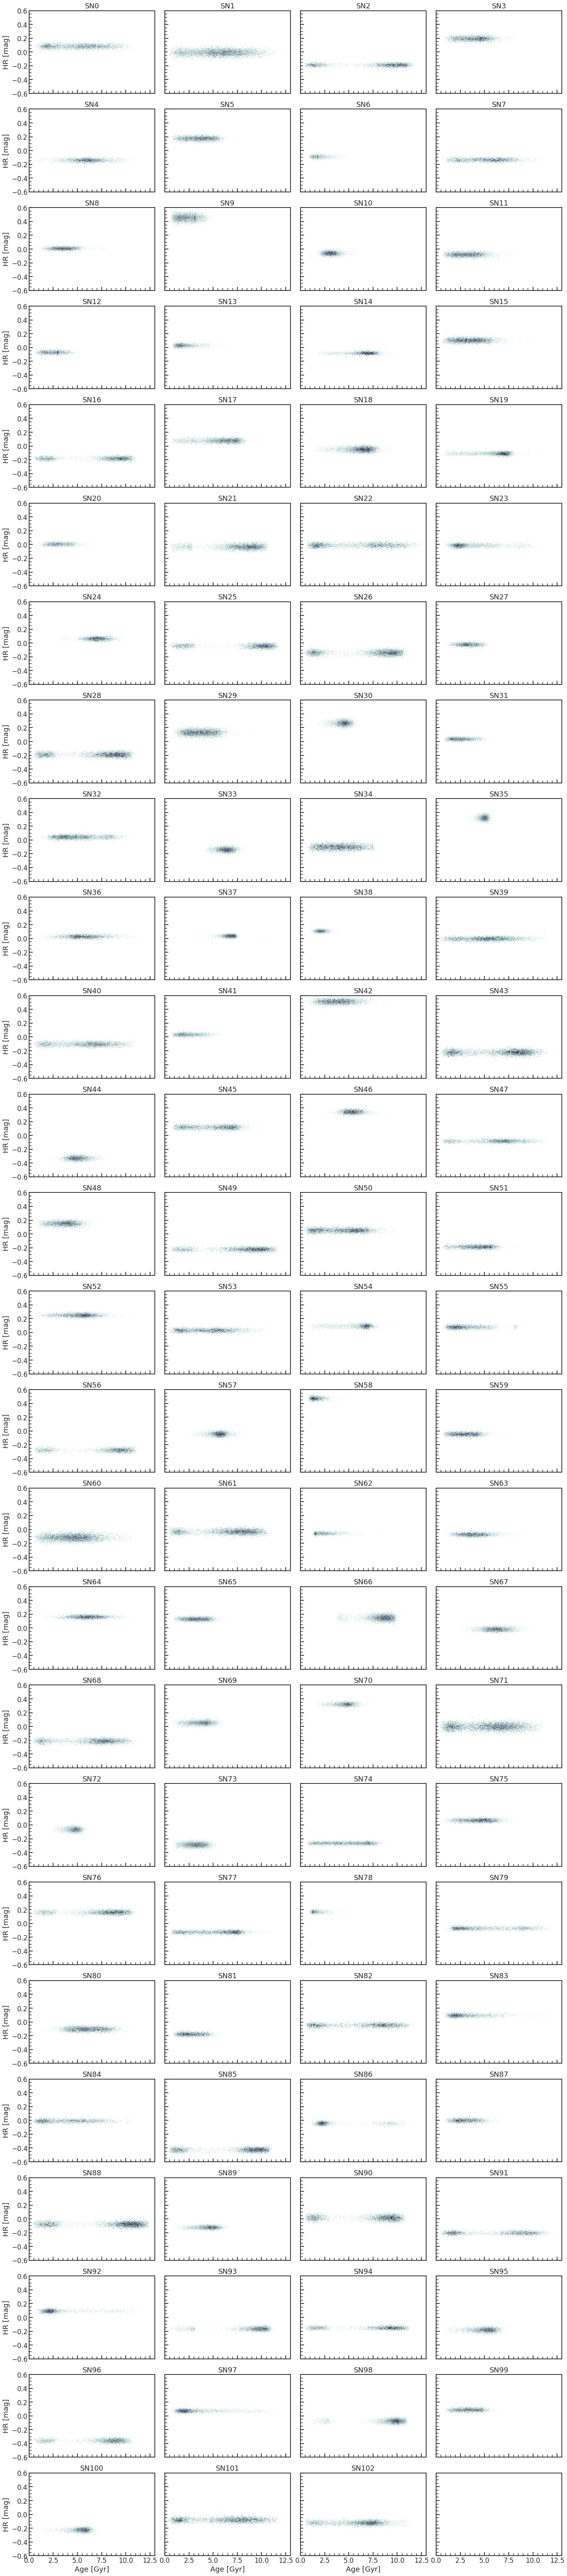

In [8]:
# plot individual
fix,axes = plt.subplots(26,4,figsize=(20,90),sharex=True,sharey=True)
for i in range(103):
    ax = axes[int(i/4)][i%4]
    SNID = samples.index.values[i]
    
    # data
    Age = samples.loc[SNID,age_columns]
    HR  = samples.loc[SNID,HR_columns]
    
    # plot
    ax.hist2d(Age,HR,bins=100,cmap='bone_r')
    ax.set_title('SN{}'.format(SNID))
    ax.set_xlim(0,13)
    ax.set_ylim(-0.6,0.6)
    if int(i/4) == 25:
        ax.set_xlabel('Age [Gyr]')
    if i%4 == 0:
        ax.set_ylabel('HR [mag]')
plt.tight_layout()
plt.savefig('figures/HRvsAge_individual_Campbell10k.pdf')

### (2-2) overall

In [9]:
np.corrcoef(stats.rankdata(Age_all, method="ordinal"), stats.rankdata(HR_all, method="ordinal"))[0, 1], stats.spearmanr(Age_all, HR_all)[0]

(-0.2117887029888756, -0.21178870291070148)

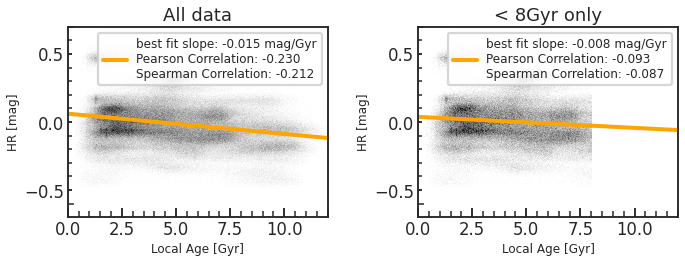

In [10]:
Nbins = 300
cmap = 'gray_r'
x_th = np.linspace(0,14,10)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

# Calculate correlations and slope for all
corr = stats.pearsonr(Age_all, HR_all)[0]
rank_corr = stats.spearmanr(Age_all, HR_all)[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all, HR_all)
y_th = x_th * popt[0] + popt[1]

ax1.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax1.hist2d(Age_all, HR_all,bins=Nbins,cmap=cmap)
ax1.set_title('All data')

# Calculate correlation and slope for <8Gyr
corr = stats.pearsonr(Age_all[Age_all<8], HR_all[Age_all<8])[0]
rank_corr = stats.spearmanr(Age_all[Age_all<8], HR_all[Age_all<8])[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all[Age_all<8], HR_all[Age_all<8])
y_th = x_th * popt[0] + popt[1]

ax2.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax2.hist2d(Age_all[Age_all<8], HR_all[Age_all<8],bins=Nbins,cmap=cmap)
ax2.set_title('< 8Gyr only')

for ax in [ax1,ax2]:
    ax.legend(fontsize=12)
    ax.set_xlabel('Local Age [Gyr]',fontsize=12)
    ax.set_ylabel('HR [mag]',fontsize=12)
    ax.set_xlim(0,12)
    ax.set_ylim(-0.7,0.7)
plt.tight_layout()
plt.savefig('figures/HRvsAge_overall_campbell10k.pdf')

## (3) age gap?

In [11]:
# downsample
HR_1k = HR_all[::100]
Age_1k = Age_all[::100]

### no-slope model

In [12]:
# no-slope model
with pm.Model() as model:
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), b1, b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace0 = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

NameError: name 'pm' is not defined

In [ ]:
az.plot_trace(trace0);
summary0 = az.summary(trace0,round_to=3)

### single-slope model

In [ ]:
with pm.Model() as model:
    a = pm.Normal('a',0,0.01)
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), a*Age_1k+b1, a*Age_1k+b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

In [ ]:
az.plot_trace(trace);
summary1 = az.summary(trace,round_to=3)

### double-slope model

In [ ]:
with pm.Model() as model2:
    a1 = pm.Normal('a1',0,0.01)
    a2 = pm.Normal('a2',0,0.01)
    b1 = pm.Normal('b1',0,0.01)
    b2 = pm.Normal('b2',0,0.01)
    c = pm.Uniform('c',lower=np.min(Age_1k),upper=np.max(Age_1k))
    sigma = pm.Normal('sigma',0.1,1)
    
    model = pm.math.switch((Age_1k<c), a1*Age_1k+b1, a2*Age_1k+b2)
    likelihood = pm.Normal('likelihood',model,sigma,observed=HR_1k)
    
    step = pm.Slice()
    trace2 = pm.sample(4000,tune=2000,step=step,
                      idata_kwargs={'log_likelihood':False})

In [ ]:
az.plot_trace(trace2);
summary2 = az.summary(trace2,round_to=3)

### plot

In [ ]:
# no-slope model
b1_0 = summary0.loc['b1','mean']
b2_0 = summary0.loc['b2','mean']
c0 = summary0.loc['c','mean']

x0 = np.linspace(0,c0,10)
x01 = np.linspace(c0,13,10)
y0 = np.full(x0.shape,b1_0)
y01 = np.full(x01.shape,b2_0)

In [ ]:
# single-slope model
a0 = summary1.loc['a','mean']
b1_1 = summary1.loc['b1','mean']
b2_1 = summary1.loc['b2','mean']
c1 = summary1.loc['c','mean']

x1 = np.linspace(0,c1,10)
x2 = np.linspace(c1,13,10)
y1 = a0*x1+b1_1
y2 = a0*x2+b2_1

In [ ]:
# double-slope model
a1 = summary2.loc['a1','mean']
a2 = summary2.loc['a2','mean']
b1_2 = summary2.loc['b1','mean']
b2_2 = summary2.loc['b2','mean']
c2 = summary2.loc['c','mean']

x3 = np.linspace(0,c2,10)
x4 = np.linspace(c2,13,10)
y3 = a1*x3+b1_2
y4 = a2*x4+b2_2

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax1.plot(x0,y0,c='b',lw=3,label=f'slope=0 mag/Gyr')
ax1.plot(x01,y01,c='r',lw=3,label=f'slope=0 mag/Gyr')
ax1.set_title(f'no-slope model\nGap = {c0:.2f}Gyr, {(b1_0-b2_0):.3f}mag')
ax1.set_xlabel('Local Age [Gyr]',fontsize=13)
ax1.set_ylabel('HR',fontsize=13)
ax1.legend()


ax2.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax2.plot(x1,y1,c='b',lw=3,label=f'slope={a0:.3f} mag/Gyr')
ax2.plot(x2,y2,c='r',lw=3,label=f'slope={a0:.3f} mag/Gyr')
ax2.set_title(f'single-slope model\nGap = {c1:.2f}Gyr, {(b1_1-b2_1):.3f}mag')
ax2.set_xlabel('Local Age [Gyr]',fontsize=13)
ax2.set_ylabel('HR',fontsize=13)
ax2.legend()

ax3.hist2d(Age_all,HR_all,bins=300,cmap='gray_r')
ax3.plot(x3,y3,c='b',lw=3,label=f'slope={a1:.3f} mag/Gyr')
ax3.plot(x4,y4,c='r',lw=3,label=f'slope={a2:.3f} mag/Gyr')
ax3.set_title(f'double-slope model\nGap = {c2:.2f}Gyr, {(b1_2-b2_2):.3f}mag')
ax3.set_xlabel('Local Age [Gyr]',fontsize=13)
ax3.set_ylabel('HR',fontsize=13)
ax3.legend()
plt.tight_layout()
plt.savefig('age_gap_campbell_local.pdf')

## (4) Correlation

* The biggest argument between Rose19 (or Rose20) and Lee20 is whether there is a correlation between ```Age_all``` and ```HR_all```.
* Possible conclusions are:

    1. not enough data points
    2. there is no correlation
    3. there is a correlation, but it is not strong enough to deny dark energy
    4. there is a strong correlation, but slope is not large enough to deny dark energy
    5. there is a strong correlation, and slope is large enough to deny dark energy


notes:
* Lee20 claims number of samples causes 'dilution problem': how can we say this claim is not on point?
* Lee20 claims 'proper method' yields a large slope. If there are correlations, what is the slope?

### Statistical Simulation - Sampling Age and Hubble Residual

To determine correlation, statistical simulation by sampling the age and HR simulation joint distribution provides a estimate of the true correlation without the need for model-fitting. For each SNe, the variablility of age and HR is accounted for with large enough samples of each distribution.

For each of the $N_\text{snid}$ SNe,

* 10000 samples without replacement of HR assuming Gaussian distribution given it respective parameters.
* 10000 samples without replacement of Age given the MCMC-derived posterior sample with no fitting of its distribution.

The total sample size is $N_\text{snid} \times 10000$

In [ ]:
def simulate(age_df, hr_df, sample_size=10000):
    sample_dfs = []
    for i, snid in enumerate(snids):
        print(f"{i}/{len(snids)}", end="\r")
        # Age ~ MCMC marginalized posterior of given SNID
        snid_age_sample = RNG.choice(age_df.loc[snid, "age"], size=sample_size)

        # HR ~ Normal(hr[snid], hr_err[snid])
        snid_hr_dist = stats.norm(loc=hr_df.loc[snid, "hr"], scale=hr_df.loc[snid, "hr_err"])
        snid_hr_dist.random_state = RNG
        snid_hr_sample = snid_hr_dist.rvs(size=sample_size)

        sample_df = pd.DataFrame({
            "age": snid_age_sample,
            "hr": snid_hr_sample
        }, index=[snid]*sample_size)
        sample_dfs.append(sample_df)

    print(f"{i+1}/{len(snids)}", end="\r")
    result_df = pd.concat(sample_dfs)
    result_df.index.name = "snid"
    result_df.to_csv(RESULTSPATH/"hr_age_simulation.csv")

def get_simulation():
    return pd.read_csv(RESULTSPATH/"hr_age_simulation.csv")

# simulate(age_df, hr_df)
result_df = get_simulation()

### Simulation Results

In [ ]:
x, y = result_df['age'], result_df['hr']
corr, pvalue_corr = stats.pearsonr(x, y)
rcorr, pvalue_rcorr = stats.spearmanr(x, y)
slope = corr * (np.std(y) / np.std(x))
intercept = np.mean(y) - slope*np.mean(x)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(x, y, c='k', s=1, alpha=1/256, zorder=100)
plt.plot(x, slope*x + intercept, zorder=200, lw=3)

plt.annotate(f"Pearson Correlation: {corr:.3f}, p={pvalue_corr:.3f}\nSpearman Correlation: {rcorr:.3f}, p={pvalue_rcorr:.3f}", xy=(0.05, 0.90), xycoords='axes fraction')
plt.xlabel("Local age [Gyr]")
plt.ylabel("Hubble residual [mag]")

In [ ]:
# similar to https://github.com/benjaminrose/MC-Age/blob/master/figures/Results-HRvsAge-redshiftcut.ipynb
fig = plt.figure(figsize=(10,10))
g = sns.jointplot(x, y,
                  kind="hex", height=8, gridsize=40, xlim=(0,12),  ylim=(-0.7, 0.7),
                  marginal_kws={'bins':30, 'kde':True, 'hist':True,
                                'kde_kws':{"shade":True},'hist_kws':{'linewidth': 0}})
g.ax_joint.plot(x, slope*x + intercept, c='orange')
g.ax_joint.tick_params(axis='both', direction='in')
g.ax_joint.set_axisbelow(False)
g.ax_joint.set_xticks([0, 2, 4, 6, 8, 10, 12])
g = g.set_axis_labels("Local age [Gyr]", 'Hubble residual [mag]')
print(f"Pearson correlation is {corr} with p-value {pvalue_corr}")
print(f"Spearman correlation is {rcorr} with p-value {pvalue_rcorr}")
print(f"Equivalent OLS parameters: slope is {slope:.3f} [mag/Gyr] and intercept is {intercept:.3f} [mag]")

In [ ]:
def standardize(z):
    return (z-np.mean(z)) / np.std(z)

x_std, y_std = standardize(x), standardize(y)

# similar to https://github.com/benjaminrose/MC-Age/blob/master/figures/Results-HRvsAge-redshiftcut.ipynb
fig = plt.figure(figsize=(10,10))
g = sns.jointplot(x_std, y_std,
                  kind="hex", height=8, gridsize=40, xlim=(0,12),  ylim=(-0.7, 0.7),
                  marginal_kws={'bins':30, 'kde':True, 'hist':True,
                                'kde_kws':{"shade":True},'hist_kws':{'linewidth': 0}})
g.ax_joint.plot(x_std, corr*y_std, c='orange')
g.ax_joint.tick_params(axis='both', direction='in')
g.ax_joint.set_axisbelow(False)
g.ax_joint.set_xticks([0, 2, 4, 6, 8, 10, 12])
g = g.set_axis_labels("Local age [Gyr]", 'Hubble residual [mag]')
print(f"Pearson correlation is {corr} with p-value {pvalue_corr}")
print(f"Spearman correlation is {rcorr} with p-value {pvalue_rcorr}")
print(f"Equivalent OLS parameters: slope is {slope:.3f} [mag/Gyr] and intercept is {intercept:.3f} [mag]")

### (4-1) Reproduce Rose19's plots

In [67]:
## global v local labels
if DATASET in ['gupta', 'campbellG']:
    xlabel = 'global age [Gyr]'
else:
    xlabel = 'local age [Gyr]'

/home/keto/.pyenv/versions/3.8.2/lib/python3.8/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/home/keto/.pyenv/versions/3.8.2/lib/python3.8/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


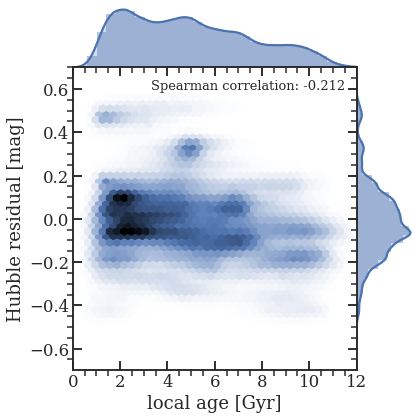

In [68]:
# similar to https://github.com/benjaminrose/MC-Age/blob/master/figures/Results-HRvsAge-redshiftcut.ipynb
sns.set(context='talk', style='ticks', font='serif', color_codes=True)
g = sns.jointplot(Age_all, HR_all, stat_func=stats.spearmanr,
                  kind="hex", gridsize=40,
                  bins=None, space=0.0, xlim=(0,12),  ylim=(-0.7, 0.7),
                  marginal_kws={'bins':30, 'kde':True, 'hist':True,
                                'kde_kws':{"shade":True},'hist_kws':{'linewidth': 0}})
g.ax_joint.tick_params(axis='both', direction='in')
g.ax_joint.set_axisbelow(False)
g.ax_joint.set_xticks([0, 2, 4, 6, 8, 10, 12])
g = g.annotate(stats.spearmanr, stat="Spearman correlation",
               loc="upper right", fontsize=13, 
               template="{stat}: {val:.3f}",
               frameon=False)
g = g.set_axis_labels(xlabel, 'Hubble residual [mag]')
plt.show()

In [48]:
dfs = []
for snid in snids:
    _df = pd.DataFrame(
    [{
        "age": np.mean(age_df.loc[snid, "age"]),
         "hr": hr_df.loc[snid, "hr"]
    }], index=[snid]) 
    dfs.append(_df)
    
summary_df = pd.concat(dfs)

0.5098039215686274


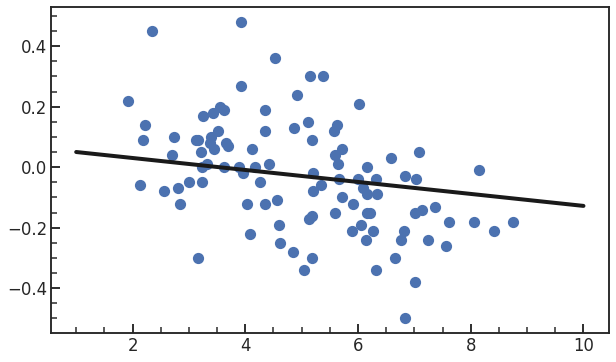

In [55]:
x, y = summary_df['age'], summary_df['hr']
xrange = np.linspace(1, 10, 100)
plt.scatter(x, y)
plt.plot(xrange, slope*xrange + intercept, c='k')

ypred = slope*x + intercept
print(np.mean(y > ypred))